# Integration of BAL Samples (v11)

In [1]:
import scanpy as sc
import sc_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sankey
import scvi
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

Global seed set to 0


In [2]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [3]:
in_dir = "01BAL/01integrated_BAL_v10"
in_name = "01integrated_BAL_v10"

adata = sc.read_h5ad(f"{data_dir}/{in_dir}/{in_name}.h5ad")
metadata = pd.read_csv(f"{data_dir}/clinical/metadata.csv")

adata

AnnData object with n_obs × n_vars = 248715 × 1000
    obs: 'SC ID', 'is_PASC', 'Status', 'Study_ID', 'old_cell_type', 'n_genes_by_counts', 'total_counts', 'n_genes', '_scvi_batch', 'cluster'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_scVI_colors', 'log1p', 'neighbors', 'old_cell_type_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


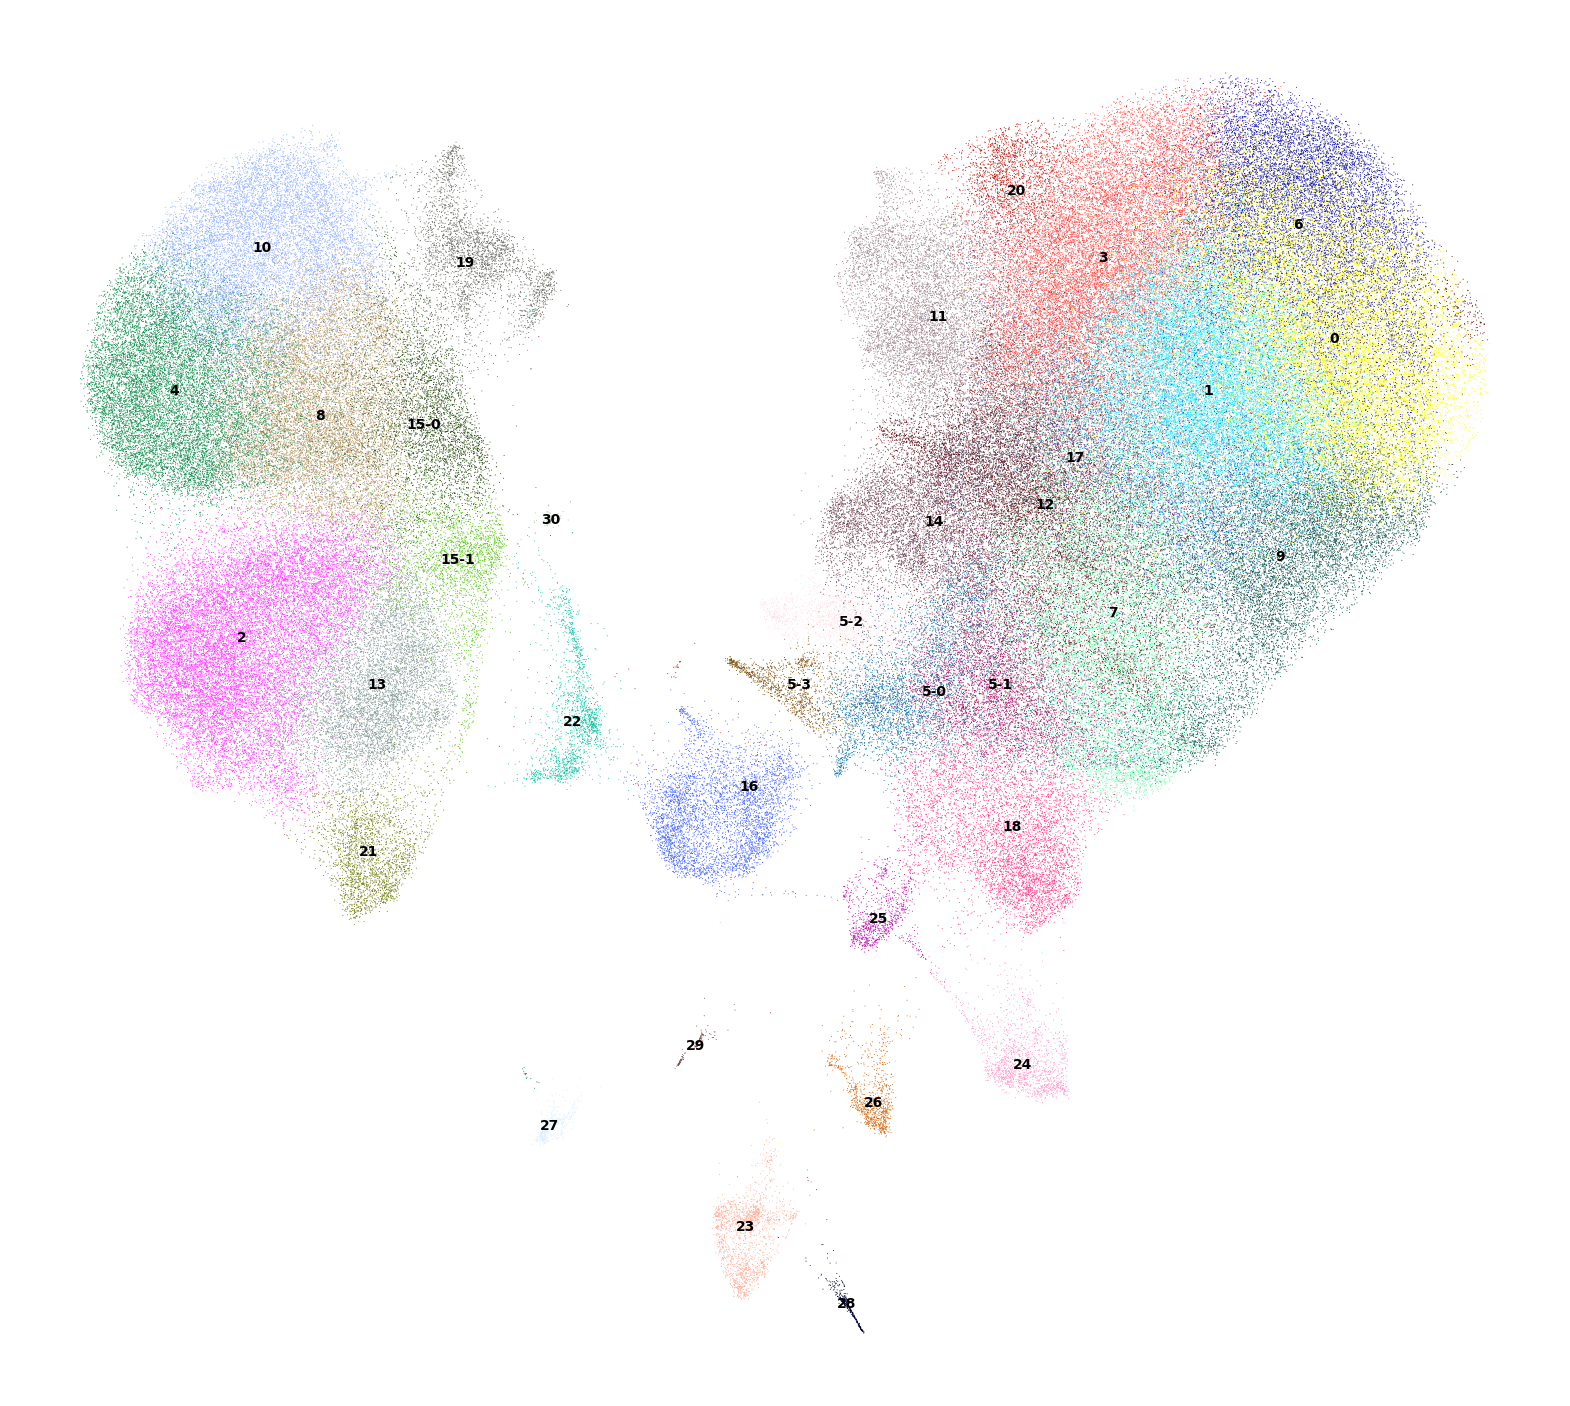

In [4]:
mpl.rcParams["figure.figsize"] = (20, 18)
sc.pl.umap(adata, color = "cluster", legend_loc = "on data", frameon = False, title = "", size = 2)

## Remove low quality clusters

In [5]:
adata = adata[~adata.obs.cluster.isin(["15-0", "15-1"])].copy()
adata

AnnData object with n_obs × n_vars = 241434 × 1000
    obs: 'SC ID', 'is_PASC', 'Status', 'Study_ID', 'old_cell_type', 'n_genes_by_counts', 'total_counts', 'n_genes', '_scvi_batch', 'cluster'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_scVI_colors', 'log1p', 'neighbors', 'old_cell_type_colors', 'rank_genes_groups', 'umap', 'cluster_colors'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Merge MoAM-1 clusters

In [6]:
adata.obs.cluster[adata.obs.cluster == "5-1"] = "5-0"

## Add cell type annotations

In [7]:
adata.obs.cluster = adata.obs.cluster.cat.remove_unused_categories()

In [8]:
annotations = {"0": "TRAM-1",
               "1": "TRAM-2",
               "2": "CD4 T cells-1",
               "3": "TRAM-3",
               "4": "CD8 T cells-1",
               "5-0": "MoAM-1",
               "5-2": "Non-classical monocytes",
               "5-3": "Classical monocytes",
               "6": "TRAM-4",
               "7": "MoAM-2",
               "8": "CD8 T cells-2",
               "9": "MoAM-3",
               "10": "CD8 T cells-3",
               "11": "TRAM-5",
               "12": "MoAM-4",
               "13": "CD4 T cells-2",
               "14": "Perivascular macrophages",
               "16": "Proliferating macrophages",
               "17": "TRAM-6",
               "18": "DC2",
               "19": "gdT cells and NK cells",
               "20": "TRAM-7",
               "21": "Tregs",
               "22": "Proliferating T cells",
               "23": "B cells",
               "24": "DC1",
               "25": "Migratory DC",
               "26": "pDC",
               "27": "Mast cells",
               "28": "Plasma cells",
               "29": "Epithelial cells",
               "30": "SARS-CoV-2"}
adata.obs["cell_type"] = adata.obs['cluster'].map(annotations).astype('category')

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


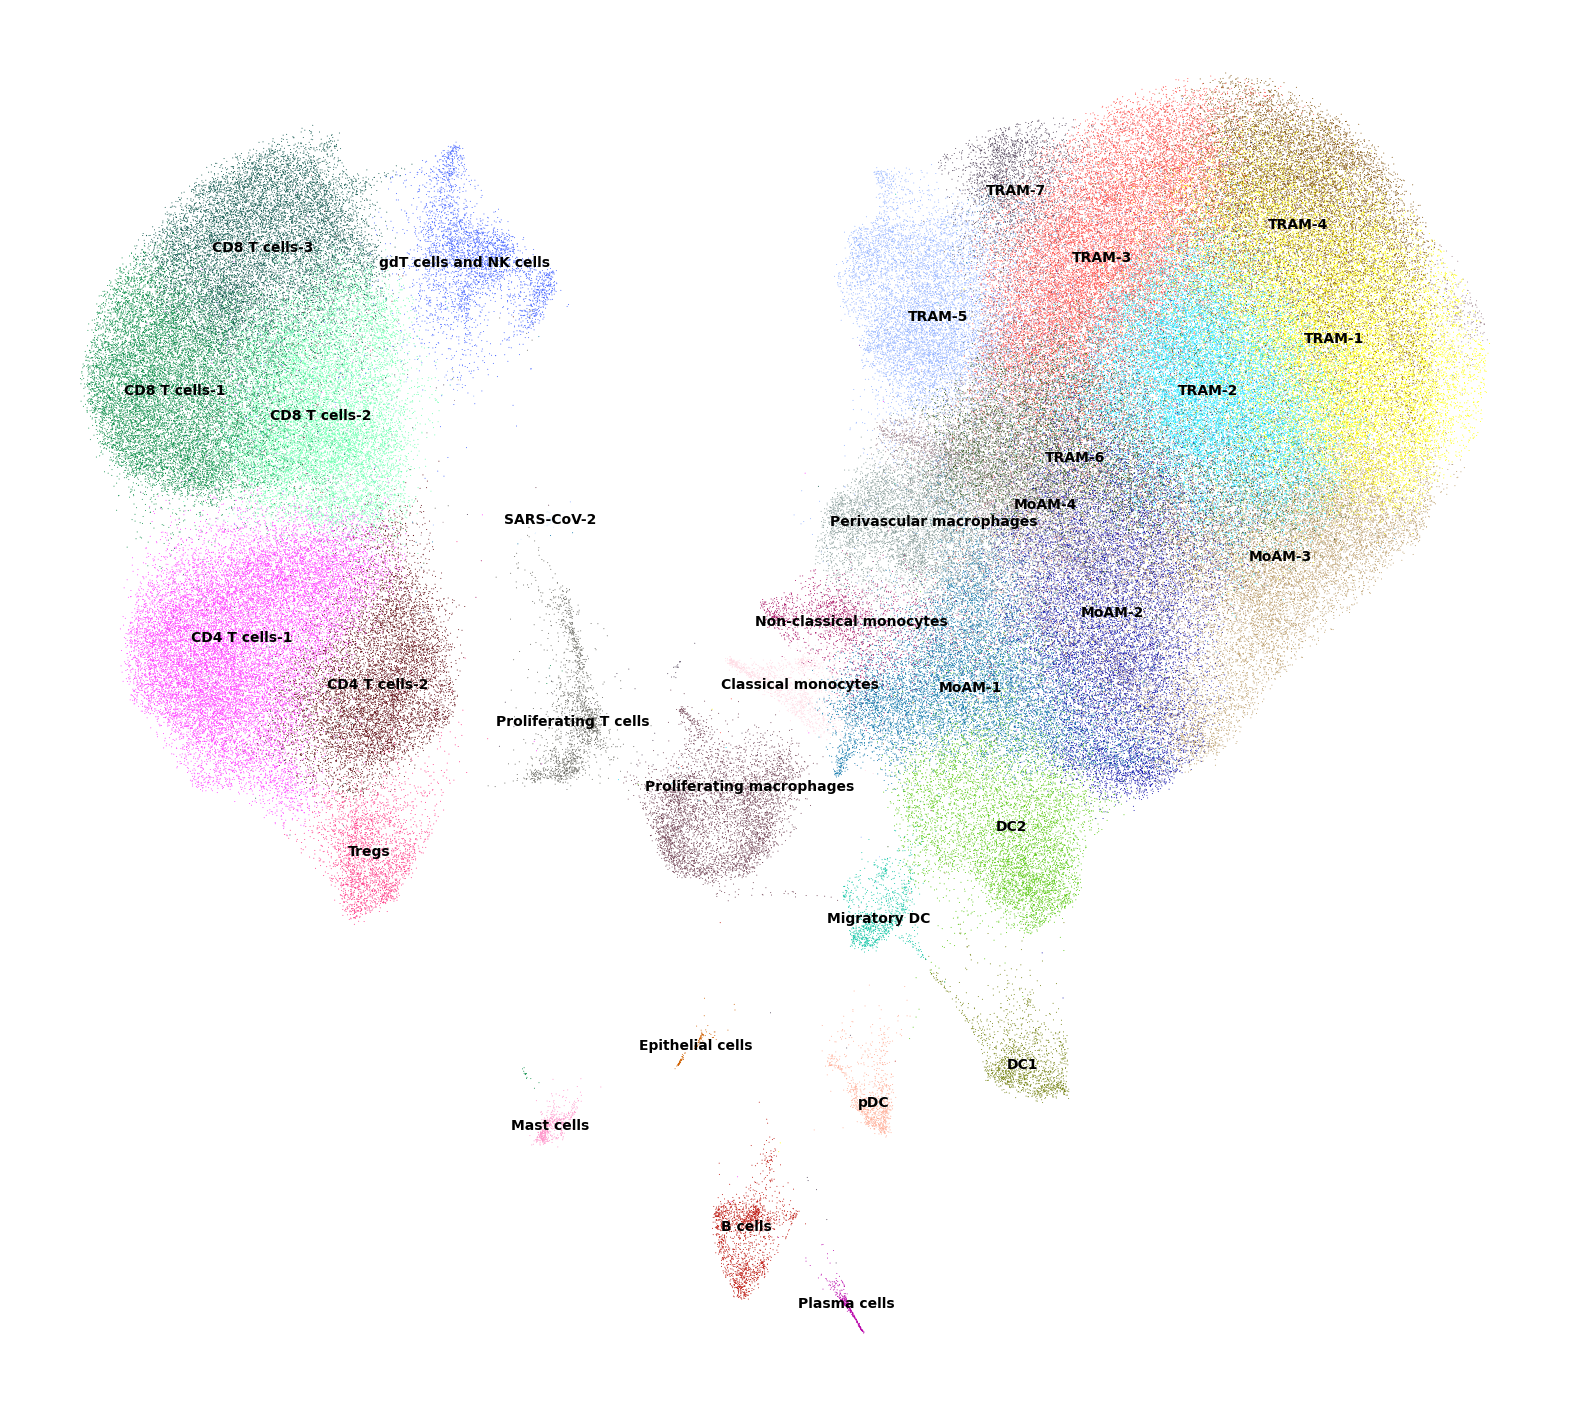

In [10]:
mpl.rcParams["figure.figsize"] = (20, 18)
ax = sc.pl.umap(adata, color = "cell_type", legend_loc = "on data", frameon = False, title = "", size = 2)

## Compute cluster markers

In [14]:
adata.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata, "cell_type", method = "wilcoxon", n_genes = 200)

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:399: Performanc

In [15]:
markers = sc_utils.get_markers(adata, "cell_type")
pd.options.display.max_rows = 500
markers.groupby("cluster").apply(lambda x: x.sort_values("avg_logFC", ascending = False).head(10))

p_val  avg_logFC     pct.1     pct.2  \
cluster                                                                        
B cells                   4800   0.000000e+00  12.459498  0.935294  0.001331   
                          4801   0.000000e+00  10.241310  0.829412  0.003016   
                          4987   2.072240e-40   9.794456  0.190588  0.000476   
                          4842  1.103885e-200   9.614582  0.428235  0.001752   
                          4817  2.667028e-270   9.535253  0.497647  0.003320   
                          4958   4.592954e-56   9.253481  0.225294  0.000784   
                          4898   6.473911e-97   9.243884  0.297059  0.001064   
                          4847  2.665895e-190   9.054291  0.417059  0.001485   
                          4884  2.554925e-118   8.543936  0.328235  0.000667   
                          4944   9.400136e-64   8.533154  0.240588  0.000888   
CD4 T cells-1             454    0.000000e+00   5.621582  0.400157  0.014472   
                          400    0.000000e+00   4.073140  0.934134  0.245964   
                          528    0.000000e+00   3.814240  0.279394  0.026029   
                          485    0.000000e+00   3.562804  0.372369  0.048810   
                          401    0.000000e+00   3.470821  0.832593  0.212062   
                          554    0.000000e+00   3.346142  0.251136  0.032165   
                          530    0.000000e+00   3.325199  0.291303  0.041365   
                          436    0.000000e+00   3.321244  0.528441  0.090423   
                          473    0.000000e+00   3.242920  0.403500  0.070786   
                          402    0.000000e+00   3.226373  0.830295  0.199992   
CD4 T cells-2             3188  2.912323e-147   5.686198  0.173758  0.005461   
                          3113   0.000000e+00   4.935732  0.301533  0.015299   
                          3126   0.000000e+00   4.705193  0.264378  0.015578   
                          3137  2.020179e-273   4.471748  0.244513  0.014853   
                          3157  1.766928e-212   4.186022  0.217535  0.014943   
                          3006   0.000000e+00   3.780656  0.783936  0.251574   
                          3022   0.000000e+00   3.254550  0.752299  0.405647   
                          3140  7.859485e-265   3.214437  0.262170  0.036994   
                          3167  1.727037e-189   3.171203  0.223421  0.033711   
                          3036   0.000000e+00   3.124678  0.674923  0.337844   
CD8 T cells-1             800    0.000000e+00   5.474017  0.988559  0.215121   
                          803    0.000000e+00   5.175331  0.732631  0.053980   
                          818    0.000000e+00   4.879898  0.700874  0.055314   
                          801    0.000000e+00   4.571548  0.821592  0.086749   
                          812    0.000000e+00   4.419521  0.739911  0.074397   
                          853    0.000000e+00   3.959181  0.583900  0.063499   
                          837    0.000000e+00   3.718603  0.667522  0.102188   
                          805    0.000000e+00   3.651966  0.937526  0.260066   
                          832    0.000000e+00   3.533586  0.697684  0.126095   
                          816    0.000000e+00   3.382638  0.816114  0.196007   
CD8 T cells-2             2000   0.000000e+00   4.504187  0.934389  0.224153   
                          2014   0.000000e+00   3.432425  0.694262  0.151631   
                          2026   0.000000e+00   3.408911  0.609972  0.104174   
                          2048   0.000000e+00   3.268990  0.516423  0.091937   
                          2063   0.000000e+00   3.184266  0.438069  0.075547   
                          2009   0.000000e+00   3.172776  0.877087  0.268694   
                          2138  8.479271e-234   3.074938  0.202770  0.031180   
                          2082   0.000000e+00   3.062497  0.356945  0.062500   
                          2078   0.00000

## Write output

In [16]:
out_version = "v11"
out_dir = f"01BAL/01integrated_BAL_{out_version}"
out_name = f"01integrated_BAL_{out_version}"

In [17]:
adata.write(f"{data_dir}/{out_dir}/{out_name}.h5ad")
adata.obs.to_csv(f"{data_dir}/{out_dir}/{out_name}-metadata.csv")
markers.to_csv(f"{data_dir}/{out_dir}/{out_name}-markers.csv")